Phase 1: Data Login Verification
1.1 Event Verification
	• Verify correct naming convention for each event
	• Confirm accurate counts for: 
		○ Number of recall trials
		○ Number of encoding words
		○ Number of simulation trials
		○ Number of trials per session
1.2 Stimulus Delivery Validation
	• Confirm all stimuli were delivered correctly
	• Verify stimulus timing accuracy
Phase 2: Frequency Analysis (3-8 Hz Peak Detection)
2.1 Non-Stimulus Periods
	• Verify that all non-stimulus periods lack the 3-8 Hz peak
	• Document any unexpected frequency responses
2.2 Stimulus Periods
	• Confirm that 3-8 Hz peak alternates appropriately during stimulus sets
	• Verify that only the stimulus channel exhibits this frequency effect during stimulus presentation
Phase 3: Channel Quality Assessment
3.1 Artifact Detection
	• Perform artifact detection across all non-stimulus periods
	• Calculate z-scores for each channel
	• Identify channels contributing most significantly to artifacts
	• Flag any channels with poor signal quality
Quality Control Checklist
	• Event naming verified
	• Trial counts confirmed
	• Stimulus delivery validated
	• Frequency analysis completed
	• Artifact detection performed
Problem channels identified

In [1]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J'  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings

# Configure pandas and warnings
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

whole_df = cml.CMLReader.get_data_index()
# 'R1620J' # R1637T
sub_df = whole_df.query('experiment == @exp and subject == @subject')


In [3]:

sub_df_exp = 'EFRCourierOpenLoop'
sub_df_session = sub_df['session'].iloc[0]
reader = cml.CMLReader(subject, exp, session=sub_df_session)
evs = reader.load('task_events')


In [4]:
print(f"START events: {len(evs[evs['type']=='START'])} / 1")
print(f"store mappings events: {len(evs[evs['type']=='store mappings'])} / 1")
print(f"SESS_END events: {len(evs[evs['type']=='SESS_END'])} / 1")
# Trial boundaries
print(f"TRIAL_START events: {len(evs[evs['type']=='TRIAL_START'])} / 5")
print(f"TRIAL_END events: {len(evs[evs['type']=='TRIAL_END'])} / 5")
# Stimulus presentation
print(f"WORD events: {len(evs[evs['type']=='WORD'])} / 60")
print(f"STIM events: {len(evs[evs['type']=='STIM'])} / 89 or 91")
# Pointing task
print(f"pointing begins events: {len(evs[evs['type']=='pointing begins'])} / 65")
print(f"pointing finished events: {len(evs[evs['type']=='pointing finished'])} / 65")
#print(f"POINTER_ON events: {len(evs[evs['type']=='POINTER_ON'])}")
# Free recall
print(f"REC_START events: {len(evs[evs['type']=='REC_START'])} / 5")
#print(f"REC_WORD events: {len(evs[evs['type']=='REC_WORD'])}")
#print(f"REC_WORD_VV events: {len(evs[evs['type']=='REC_WORD_VV'])}")
print(f"REC_STOP events: {len(evs[evs['type']=='REC_STOP'])} / 5")
# Cued recall
print(f"CUED_REC_CUE events: {len(evs[evs['type']=='CUED_REC_CUE'])} / 60")
#print(f"CUED_REC_WORD events: {len(evs[evs['type']=='CUED_REC_WORD'])}")
#print(f"CUED_REC_WORD_VV events: {len(evs[evs['type']=='CUED_REC_WORD_VV'])}")
print(f"CUED_REC_STOP events: {len(evs[evs['type']=='CUED_REC_STOP'])} / 60")
# Serial recall
print(f"FSR_START events: {len(evs[evs['type']=='FSR_START'])}")
#print(f"SR_REC_WORD events: {len(evs[evs['type']=='SR_REC_WORD'])}")
#print(f"SR_REC_WORD_VV events: {len(evs[evs['type']=='SR_REC_WORD_VV'])}")
print(f"FSR_STOP events: {len(evs[evs['type']=='FSR_STOP'])}")
# Final free recall
print(f"FFR_START events: {len(evs[evs['type']=='FFR_START'])}")
#print(f"FFR_REC_WORD events: {len(evs[evs['type']=='FFR_REC_WORD'])}")
#print(f"FFR_REC_WORD_VV events: {len(evs[evs['type']=='FFR_REC_WORD_VV'])}")
print(f"FFR_STOP events: {len(evs[evs['type']=='FFR_STOP'])}")
# Other markers
#print(f"EFR_MARK events: {len(evs[evs['type']=='EFR_MARK'])}")

START events: 1 / 1
store mappings events: 1 / 1
SESS_END events: 1 / 1
TRIAL_START events: 5 / 5
TRIAL_END events: 5 / 5
WORD events: 60 / 60
STIM events: 147 / 89 or 91
pointing begins events: 65 / 65
pointing finished events: 65 / 65
REC_START events: 5 / 5
REC_STOP events: 5 / 5
CUED_REC_CUE events: 60 / 60
CUED_REC_STOP events: 60 / 60
FSR_START events: 1
FSR_STOP events: 1
FFR_START events: 1
FFR_STOP events: 1


In [5]:
# try to find the index when the stimuli is applied in 8 hz, 3 hx and when no stimuli is applied 
pulse_freq_data=[]
word_data_type=[]
for i in range(len(evs['stim_params'])):
    freq_data=evs['stim_params'].iloc[i]['burst_freq']
    word_data=evs['type'].iloc[i]
    pulse_freq_data.append(freq_data)
    word_data_type.append(word_data)
evs['stim_params']
indices_with_8 = np.where(np.array(pulse_freq_data) == 8)[0].tolist()
indices_with_3 = np.where(np.array(pulse_freq_data) == 3)[0].tolist()
indices_with_no = np.where(np.array(pulse_freq_data)[:-1] == -1)[0] + 1
indices_with_no = indices_with_no.tolist()

In [ ]:
evs['stim_params'].iloc[143]

In [6]:
# add 'phase' column to events df (with 'encoding', 'retrieval' for FR, FFR (final FR) or FSR (final store recall))
def add_phase(evs):
    new_evs = pd.DataFrame([])
    for ind,list_evs in evs.groupby('trial'): # 'trial' is the aquivalent of a delivery day
        if list_evs['trial'].unique()!=-999:
            list_evs['phase']='nan'

            # find indexes of encoding start and end
            first_pointing_index = min(list_evs[list_evs['type']=='pointing begins'].index)
            navigation_end_index = min(list_evs[list_evs['type']=='TRIAL_END'].index)-1
            list_evs.loc[first_pointing_index:navigation_end_index]['phase']='encoding'

            # find indexes of retrieval start and end
            rec_start_index = list_evs[list_evs['type']=='REC_START'].index[0]
            rec_end_index = list_evs[list_evs['type']=='REC_STOP'].index[0]
            list_evs.loc[rec_start_index:rec_end_index]['phase']='retrieval'

            if len(list_evs[list_evs.type=='FSR_START'])>0: # relevant only for the final trial
                # find indexes of Final FR for stores start and end
                FSR_start_index = list_evs[list_evs['type']=='FSR_START'].index[0]
                FSR_end_index = list_evs[list_evs['type']=='FSR_STOP'].index[0]
                list_evs.loc[FSR_start_index:FSR_end_index]['phase']='FSR'

                 # find indexes of Final FR for items start and end
                FFR_start_index = list_evs[list_evs['type']=='FFR_START'].index[0]
                FFR_end_index = list_evs[list_evs['type']=='FFR_STOP'].index[0]
                list_evs.loc[FFR_start_index:FFR_end_index]['phase']='FFR'

        elif list_evs['trial'].unique()==-999:
            list_evs['phase']='nan'
            

        new_evs=pd.concat([new_evs,list_evs])

    return new_evs
evs=add_phase(evs)


In [7]:

result_8HZ_encoding = evs[(evs.index.isin(indices_with_8)) & (evs['phase'] == 'encoding')]
result_3HZ_encoding = evs[(evs.index.isin(indices_with_3)) & (evs['phase'] == 'encoding')]
result_none_encoding = evs[(evs.index.isin(indices_with_no)) & (evs['phase'] == 'encoding') & (evs['type'] == 'WORD')]
result_8HZ_retrieval = evs[(evs.index.isin(indices_with_8)) & (evs['phase'] == 'retrieval')]
result_3HZ_retrieval = evs[(evs.index.isin(indices_with_3)) & (evs['phase'] == 'retrieval')]
print(f"encoding phase have 3 hz stimuli: {len(result_3HZ_encoding)}")
print(f"encoding phase have 8 hz stimuli: {len(result_8HZ_encoding)}")
print(f"encoding phase have NONE stimuli: {len(result_none_encoding)}")
print(f"retrival phase have 3 hz stimuli: {len(result_3HZ_retrieval)}")
print(f"retrival phase have 8 hz stimuli: {len(result_8HZ_retrieval)}")


encoding phase have 3 hz stimuli: 15
encoding phase have 8 hz stimuli: 12
encoding phase have NONE stimuli: 33
retrival phase have 3 hz stimuli: 45
retrival phase have 8 hz stimuli: 30


In [8]:
df = cml.get_data_index()

# Specify which subject and experiment we want
sub = 'R1620J'
exp = 'EFRCourierOpenLoop'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# Initialize data reader using session metadata
reader = cml.CMLReader(sub, exp, session=df_sess['session'],
                       localization=df_sess['localization'], montage=df_sess['montage'])

# For first session...
evs = reader.load("events")
word_evs = evs[evs['type']=='WORD']
channels = reader.load("pairs")

In [9]:
eeg_container_result_8HZ_encoding = reader.load_eeg(result_8HZ_encoding, -1000, time_window, scheme=channels)
eeg_container_result_3HZ_encoding = reader.load_eeg(result_3HZ_encoding, -1000, time_window, scheme=channels)
eeg_container_result_8HZ_retrieval = reader.load_eeg(result_8HZ_retrieval, -1000, time_window, scheme=channels)
eeg_container_result_3HZ_retrieval = reader.load_eeg(result_3HZ_retrieval, -1000, time_window, scheme=channels)
eeg_container_result_encoding = reader.load_eeg(result_none_encoding, -1000, time_window, scheme=channels)
eeg_8HZ = eeg_container_result_8HZ_encoding.data
eeg_3HZ = eeg_container_result_3HZ_encoding.data
eeg_8HZ_retrieval = eeg_container_result_8HZ_retrieval.data
eeg_3HZ_retrieval = eeg_container_result_3HZ_retrieval.data
eeg_no_encoding= eeg_container_result_encoding.data
sr = eeg_container_result_8HZ_encoding.samplerate


NameError: name 'pairs' is not defined

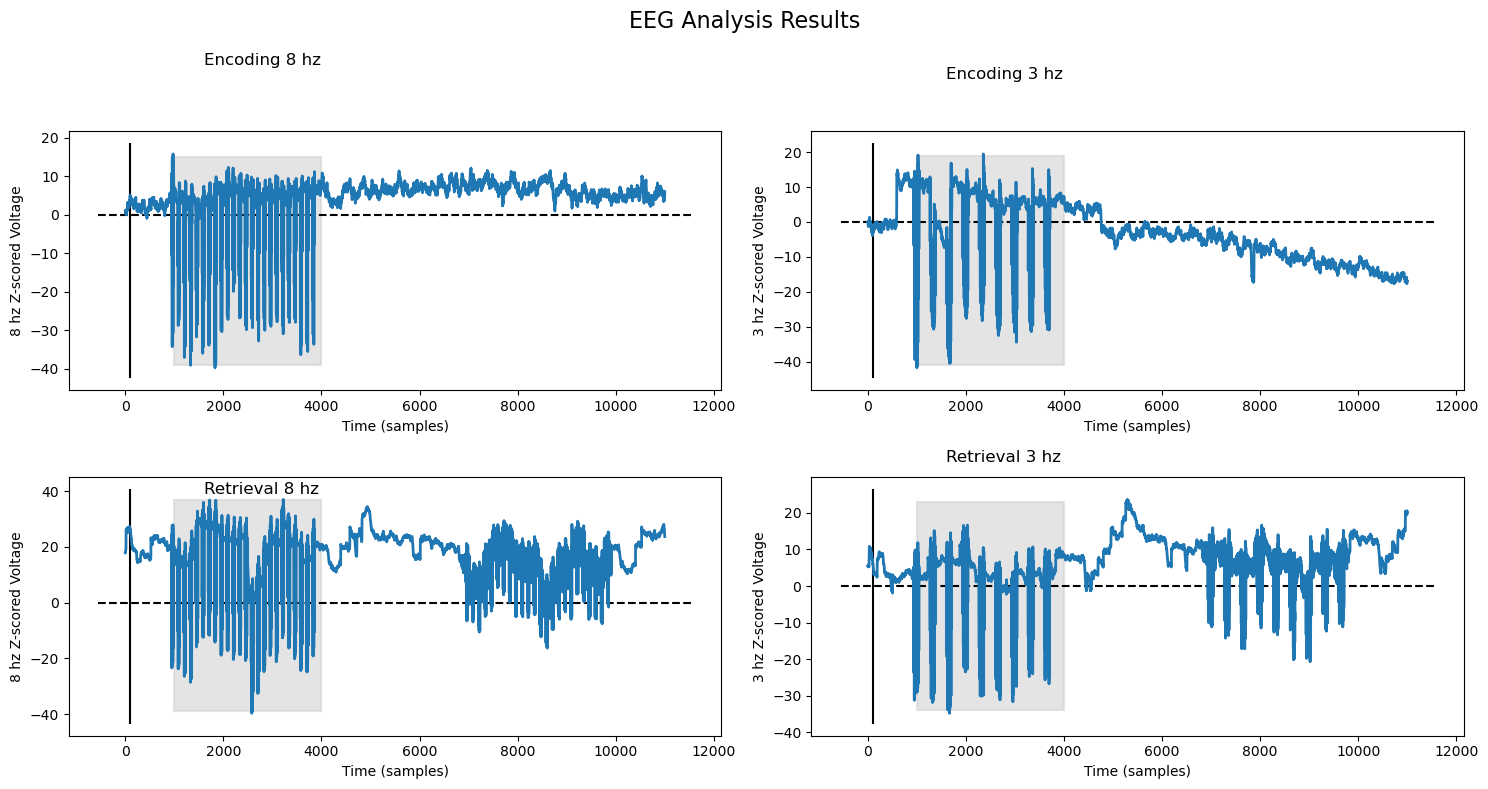

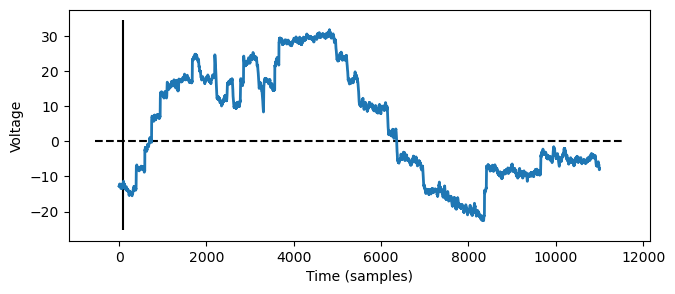

In [10]:
# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('EEG Analysis Results', fontsize=16)

# Plot 1: 8Hz Encoding
ax = axes[0, 0]
plt.sca(ax)
avg_eeg = np.mean(eeg_8HZ[:, :, :], 0)
plt.plot(np.mean(avg_eeg[:, :], 0), linewidth=2)
height = np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))) + int(np.max(np.mean(avg_eeg[:, :], 0)))
plt.vlines([0.1*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('8 hz Z-scored Voltage')
rect = plt.Rectangle((1000, int(np.min(np.mean(avg_eeg[:, :], 0)))), 3000, height, linewidth=1.5, fill=True, alpha=0.6, facecolor='lightgrey', edgecolor='lightgrey', linestyle='-')
plt.text(1600, np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))), 'Encoding 8 hz', fontsize=12)
ax.add_patch(rect)

# Plot 2: 3Hz Encoding
ax = axes[0, 1]
plt.sca(ax)
avg_eeg = np.mean(eeg_3HZ[:, :, :], 0)
plt.plot(np.mean(avg_eeg[:, :], 0), linewidth=2)
height = np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))) + int(np.max(np.mean(avg_eeg[:, :], 0)))
plt.vlines([0.1*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('3 hz Z-scored Voltage')
rect = plt.Rectangle((1000, int(np.min(np.mean(avg_eeg[:, :], 0)))), 3000, height, linewidth=1.5, fill=True, alpha=0.6, facecolor='lightgrey', edgecolor='lightgrey', linestyle='-')
plt.text(1600, np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))), 'Encoding 3 hz', fontsize=12)
ax.add_patch(rect)

# Plot 3: 8Hz Retrieval
ax = axes[1, 0]
plt.sca(ax)
avg_eeg = np.mean(eeg_8HZ_retrieval[:, :, :], 0)
plt.plot(np.mean(avg_eeg[:, :], 0), linewidth=2)
height = np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))) + int(np.max(np.mean(avg_eeg[:, :], 0)))
plt.vlines([0.1*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('8 hz Z-scored Voltage')
rect = plt.Rectangle((1000, int(np.min(np.mean(avg_eeg[:, :], 0)))), 3000, height, linewidth=1.5, fill=True, alpha=0.6, facecolor='lightgrey', edgecolor='lightgrey', linestyle='-')
plt.text(1600, np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))), 'Retrieval 8 hz', fontsize=12)
ax.add_patch(rect)

# Plot 4: 3Hz Retrieval
ax = axes[1, 1]
plt.sca(ax)
avg_eeg = np.mean(eeg_3HZ_retrieval[:, :, :], 0)
plt.plot(np.mean(avg_eeg[:, :], 0), linewidth=2)
height = np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))) + int(np.max(np.mean(avg_eeg[:, :], 0)))
plt.vlines([0.1*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('3 hz Z-scored Voltage')
rect = plt.Rectangle((1000, int(np.min(np.mean(avg_eeg[:, :], 0)))), 3000, height, linewidth=1.5, fill=True, alpha=0.6, facecolor='lightgrey', edgecolor='lightgrey', linestyle='-')
plt.text(1600, np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))), 'Retrieval 3 hz', fontsize=12)
ax.add_patch(rect)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Optional: Plot the "no stimuli" condition separately if needed
plt.figure(figsize=(7.5, 3))
avg_eeg = np.mean(eeg_no_encoding[:, :, :], 0)
plt.plot(np.mean(avg_eeg[:, :], 0), linewidth=2)
height = np.abs(int(np.min(np.mean(avg_eeg[:, :], 0)))) + int(np.max(np.mean(avg_eeg[:, :], 0)))
plt.vlines([0.1*sr], ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=plt.gca().get_xlim()[0], xmax=plt.gca().get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('Voltage')
rect = plt.Rectangle((1000, int(np.min(np.mean(avg_eeg[:, :], 0)))), 3000, height, linewidth=1.5, fill=True, alpha=0.6, facecolor='lightgrey', edgecolor='lightgrey', linestyle='-')

plt.show()


In [ ]:
pairs = reader.load('pairs')



In [ ]:
stim_index=indices_with_8

labels=pd.DataFrame([])
# burst_freq = []
for ind in stim_index:
    stim_params=evs['stim_params'].loc[ind]
    anode_label=stim_params['anode_label']
    cathode_label=stim_params['cathode_label']
    label1 = [anode_label+'-'+cathode_label]
    label2 = [cathode_label+'-'+anode_label]
    labels = labels.append(label1)
    labels = labels.append(label2)
#     burst_freq.append(stim_params['burst_freq'])

labels[0].unique()
labels=labels[0].unique()

In [ ]:
import re
all_stimuli_channel_indices_8hz=[]
all_stimuli_indices_8hz=[]
for label in labels:
    # Exact match
    mask = pairs['label'].str.contains(label, na=False)
    stimuli_indices_8hz = pairs.loc[mask].index
    
    # Flexible match - remove numbers from both the search term AND the data
    cleaned_label = re.sub(r'\d+', '', label)
    mask_channel = pairs['label'].str.replace(r'\d+', '', regex=True).str.contains(cleaned_label, na=False)
    stimuli_channel_indices_8hz = pairs.loc[mask_channel].index
    all_stimuli_indices_8hz.extend(stimuli_indices_8hz)
    all_stimuli_channel_indices_8hz.extend(stimuli_channel_indices_8hz)
ALLother = list(range(1, len(pairs)))
# Remove all indices that are in stimuli_channel_indices_8hz
Index_other_8 = [x for x in ALLother if x not in all_stimuli_channel_indices_8hz]
Channel_stimuli_8= [x for x in all_stimuli_channel_indices_8hz if x not in all_stimuli_indices_8hz]
Conntact_stimuli_8=all_stimuli_indices_8hz

In [ ]:
stim_index=indices_with_3

labels=pd.DataFrame([])
# burst_freq = []
for ind in stim_index:
    stim_params=evs['stim_params'].loc[ind]
    anode_label=stim_params['anode_label']
    cathode_label=stim_params['cathode_label']
    label1 = [anode_label+'-'+cathode_label]
    label2 = [cathode_label+'-'+anode_label]
    labels = labels.append(label1)
    labels = labels.append(label2)
#     burst_freq.append(stim_params['burst_freq'])

labels[0].unique()
labels=labels[0].unique()

In [ ]:
# Remove all indices that are in stimuli_channel_indices_8hz

import re
all_stimuli_channel_indices_3hz=[]
all_stimuli_indices_3hz=[]
for label in labels:
    # Exact match
    mask = pairs['label'].str.contains(label, na=False)
    stimuli_indices_3hz = pairs.loc[mask].index
    
    # Flexible match - remove numbers from both the search term AND the data
    cleaned_label = re.sub(r'\d+', '', label)
    mask_channel = pairs['label'].str.replace(r'\d+', '', regex=True).str.contains(cleaned_label, na=False)
    stimuli_channel_indices_3hz = pairs.loc[mask_channel].index
    all_stimuli_indices_3hz.extend(stimuli_indices_3hz)
    all_stimuli_channel_indices_3hz.extend(stimuli_channel_indices_3hz)
ALLother = list(range(1, len(pairs)))
# Remove all indices that are in stimuli_channel_indices_8hz
Index_other_3 = [x for x in ALLother if x not in all_stimuli_channel_indices_3hz]
Channel_stimuli_3= [x for x in all_stimuli_channel_indices_3hz if x not in all_stimuli_indices_3hz]
Conntact_stimuli_3=all_stimuli_indices_3hz

In [ ]:
Conntact_stimuli_3

In [ ]:
avg_eeg_other = np.mean(eeg_3HZ[:, Index_other_3, :], axis=0)
avg_eeg_stimuli = np.mean(eeg_3HZ[:, Conntact_stimuli_3, :],0)
avg_eeg_channel = np.mean(eeg_3HZ[:, Channel_stimuli_3, :],0)


In [ ]:
# Create figure with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('8 Hz EEG Analysis', fontsize=16)

# Calculate average EEG data for different channel groups
avg_eeg_other = np.mean(eeg_8HZ[:, Index_other_8, :], axis=1)
avg_eeg_stimuli = np.mean(eeg_8HZ[:, Conntact_stimuli_8, :],1)
avg_eeg_channel = np.mean(eeg_8HZ[:, Channel_stimuli_8, :],1)

# Prepare data for plotting
data_other = np.mean(avg_eeg_other, axis=0)
data_stimuli = np.mean(avg_eeg_stimuli, axis=0)
data_channel = np.mean(avg_eeg_channel , axis=0)

# Calculate global y-limits for consistent scaling
global_min = min(np.min(data_other), np.min(data_channel))
global_max = max(np.max(data_other), np.max(data_channel))
min_stim=np.min(data_stimuli)
height = np.abs(int(global_min)) + int(global_max)

# Plot 1: 8Hz Encoding (Other Channels)
ax1 = axes[0]
plt.sca(ax1)
plt.plot(data_other, linewidth=2, color='blue')
ax1.set_ylim(global_min, global_max)
plt.vlines([0.1 * sr], ymin=global_min, ymax=global_max, linestyle='-', color='k')
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('8 Hz Voltage')
ax1.set_title('Encoding 8 Hz (Other Channels)', fontsize=12)

# Add shaded region
#rect1 = plt.Rectangle((1000, int(global_min)), 3000, height, 
                   #   linewidth=1.5, fill=True, alpha=0.6, 
                    #  facecolor='lightgrey', edgecolor='lightgrey')
#ax1.add_patch(rect1)

# Plot 2: 8Hz Encoding (Hippocampus Channel)
ax2 = axes[1]
plt.sca(ax2)
plt.plot(data_stimuli, linewidth=2, color='red')
#ax2.set_ylim(global_min, global_max)
#plt.vlines([0.1 * sr], ymin=global_min, ymax=global_max, linestyle='-', color='k')
plt.hlines([0], xmin=ax2.get_xlim()[0], xmax=ax2.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('8 Hz Z-scored Voltage')
ax2.set_title('Encoding 8 Hz "stimulated pairs"', fontsize=12)

# Add shaded region
rect2 = plt.Rectangle((1000, int(min_stim)), 3000, height, 
                      linewidth=1.5, fill=True, alpha=0.6, 
                      facecolor='lightgrey', edgecolor='lightgrey')
ax2.add_patch(rect2)

# Plot 3: 8Hz Encoding (Stimulated Shank)
ax3 = axes[2]
plt.sca(ax3)
plt.plot(data_channel, linewidth=2, color='green')
ax3.set_ylim(global_min, global_max)
plt.vlines([0.1 * sr], ymin=global_min, ymax=global_max, linestyle='-', color='k')
plt.hlines([0], xmin=ax3.get_xlim()[0], xmax=ax3.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('8 Hz  Voltage')
ax3.set_title('Stimuli "stimulated shank"', fontsize=12)

# Add shaded region
rect3 = plt.Rectangle((1000, int(global_min)), 3000, height, 
                      linewidth=1.5, fill=True, alpha=0.6, 
                      facecolor='lightgrey', edgecolor='lightgrey')
ax3.add_patch(rect3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Create figure with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('3 Hz EEG Analysis', fontsize=16)

# Calculate average EEG data for different channel groups
avg_eeg_other = np.mean(eeg_3HZ[:, Index_other_3, :], axis=1)
avg_eeg_stimuli = np.mean(eeg_3HZ[:, Conntact_stimuli_3, :],1)
avg_eeg_channel = np.mean(eeg_3HZ[:, Channel_stimuli_3, :],1)

# Prepare data for plotting
data_other = np.mean(avg_eeg_other, axis=0)
data_stimuli = np.mean(avg_eeg_stimuli, axis=0)
data_channel = np.mean(avg_eeg_channel , axis=0)

# Calculate global y-limits for consistent scaling
global_min = min(np.min(data_other), np.min(avg_eeg_channel))
global_max = max(np.max(data_other), np.max(avg_eeg_channel))
height = np.abs(int(global_min)) + int(global_max)

# Plot 1: 3Hz Encoding (Other Channels)
ax1 = axes[0]
plt.sca(ax1)
plt.plot(data_other, linewidth=2, color='blue')
ax1.set_ylim(global_min, global_max)
plt.vlines([0.1 * sr], ymin=global_min, ymax=global_max, linestyle='-', color='k')
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('3 Hz Voltage')
ax1.set_title('Encoding 3 Hz (Other Channels)', fontsize=12)

# Add shaded region
#rect1 = plt.Rectangle((1000, int(global_min)), 3000, height, 
                #      linewidth=1.5, fill=True, alpha=0.6, 
                  #    facecolor='lightgrey', edgecolor='lightgrey')
#ax1.add_patch(rect1)

# Plot 2: 3Hz Encoding (Hippocampus Channel)
ax2 = axes[1]
plt.sca(ax2)
plt.plot(data_stimuli, linewidth=2, color='red')
#ax2.set_ylim(global_min, global_max)
#plt.vlines([0.1 * sr], ymin=global_min, ymax=global_max, linestyle='-', color='k')
plt.hlines([0], xmin=ax2.get_xlim()[0], xmax=ax2.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('3 Hz Voltage')
ax2.set_title('Encoding 3 Hz stimulated pair', fontsize=12)

# Add shaded region
rect2 = plt.Rectangle((1000, int(min_stim)), 3000, height, 
                      linewidth=1.5, fill=True, alpha=0.6, 
                      facecolor='lightgrey', edgecolor='lightgrey')
ax2.add_patch(rect2)

# Plot 3: 3Hz Encoding (Stimulated Shank)
ax3 = axes[2]
plt.sca(ax3)
plt.plot(data_channel, linewidth=2, color='green')
ax3.set_ylim(global_min, global_max)
plt.vlines([0.1 * sr], ymin=global_min, ymax=global_max, linestyle='-', color='k')
plt.hlines([0], xmin=ax3.get_xlim()[0], xmax=ax3.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)')
plt.ylabel('3 Hz Voltage')
ax3.set_title('3 Hz "stimulated shank"', fontsize=12)

# Add shaded region
rect3 = plt.Rectangle((1000, int(global_min)), 3000, height, 
                      linewidth=1.5, fill=True, alpha=0.6, 
                      facecolor='lightgrey', edgecolor='lightgrey')
ax3.add_patch(rect3)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# the average activity that is not all the shank
plt.plot(data_other, linewidth=2, color='blue')

plt.title('average activity that is not all at the stimuluted shank')
plt.show()

In [ ]:
plt.plot(avg_eeg_other.T, linewidth=1)

plt.title('average activity that is not all at the stimuluted shank')
plt.show()

In [ ]:


# 1. Trial-to-trial variability for each channel and timepoint
trial_variability = np.std(eeg_no_encoding, axis=0)  # Shape: (channels, timepoints)
acrosstime_variability = np.std(eeg_no_encoding, axis=2) 
# 2. Average variability across all channels for each timepoint
timepoint_variability = np.mean(np.std(eeg_no_encoding, axis=0), axis=0)  # Shape: (timepoints,)

# 3. Average variability across all timepoints for each channel
channel_variability = np.mean(np.std(eeg_no_encoding, axis=0), axis=1)  # Shape: (channels,)

print("Trial variability shape:", trial_variability.shape)
print("Timepoint variability shape:", timepoint_variability.shape)
print("Channel variability shape:", channel_variability.shape)
ForTime=np.mean(acrosstime_variability,1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute trial variability
trial_variability = np.std(eeg_no_encoding, axis=0)  # Shape: (channels, timepoints)

# 1. Heatmap visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Heatmap of trial variability
plt.subplot(2, 2, 1)
plt.imshow(trial_variability, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Standard Deviation')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.title('Trial Variability Heatmap\n(All Channels × All Timepoints)')

# Subplot 2: Average variability across channels for each timepoint
plt.subplot(2, 2, 2)
timepoint_variability = np.mean(trial_variability, axis=0)
plt.plot(timepoint_variability, linewidth=2)
plt.xlabel('Time Points')
plt.ylabel('Average Standard Deviation')
plt.title('Average Trial Variability Across Time')
plt.grid(True, alpha=0.3)

# Subplot 3: Average variability across timepoints for each channel
plt.subplot(2, 2, 3)
channel_variability = np.mean(trial_variability, axis=1)
M = channel_variability-np.mean(channel_variability)
sd=np.std(channel_variability)
Z_channel_variability=M/sd
plt.plot(Z_channel_variability, linewidth=2)
plt.xlabel('Channel Number')
plt.ylabel('Average Standard Deviation')
plt.title('Average Trial Variability by Channel')
plt.grid(True, alpha=0.3)

# Subplot 4: Specific channels over time (example)
plt.subplot(2, 2, 4)
z_mask=Z_channel_variability>2
pairs.loc[z_mask]
# Plot a few example channels
channels_to_plot = pairs.loc[z_mask].index
for ch in channels_to_plot:
    plt.plot(trial_variability[ch, :], label=pairs.iloc[ch].label, linewidth=3)

plt.xlabel('Time Points')
plt.ylabel('Standard Deviation')
plt.title('Trial Variability for z-zore>2')
plt.grid(True, alpha=0.3)
plt.legend(fontsize='large')  
plt.tight_layout()
plt.show()


z_mask=Z_channel_variability>2
pairs.loc[z_mask]['label']




In [ ]:
ReportNew_TrytoGeneralize